In [1]:
import sys
sys.path.append('..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
import ccxt
import seaborn as sns
import mplfinance as mpf
from IPython.display import clear_output
from utilities.custom_indicators import get_n_columns
from utilities.get_data import get_historical_from_db

In [2]:
def get_min_max(df, column_name, candle_min_window=3):
    originals_columns = list(df.columns.copy())
    originals_columns.append(column_name+"_top")
    originals_columns.append(column_name+"_bottom")
    dt = df.copy()
    dt[column_name+"_bottom"] = 1
    dt[column_name+"_top"] = 1

    for i in range(1, candle_min_window + 1, 1):
        dt = get_n_columns(dt, [column_name], i)
        dt = get_n_columns(dt, [column_name], -i)

        dt.loc[
            (dt["n" + str(-i) + "_" + column_name] < dt[column_name]) 
            | (dt["n" + str(i) + "_" + column_name] < dt[column_name])
            , column_name+"_bottom"
        ] = 0

        dt.loc[
            (dt["n" + str(-i) + "_" + column_name] > dt[column_name]) 
            | (dt["n" + str(i) + "_" + column_name] > dt[column_name])
            , column_name+"_top"
        ] = 0
    dt = dt.loc[:,originals_columns]

    return dt

def get_df_top_divergence(df_top, df_top_indicator, indicator_name, base_column="close", top_concordance=True, max_period_check=100):
    top_scopes = []
    for index, row in df_top.iterrows():
        min_scope = -1000000
        min_window_diff = 10
        top_indicator_index = list(df_top_indicator["iloc"])
        try:
            current_df = df_top.copy().loc[df_top.index > index]
            base_point_date = row["date"]
            base_point_iloc = row["iloc"]
            base_point_value = row[base_column]
            base_point_indicator_value = row[indicator_name]
            for current_row in current_df.to_dict(orient="records"):
                scope = (current_row[base_column] - base_point_value) / (current_row["iloc"] - base_point_iloc)
                if base_point_iloc + max_period_check < current_row["iloc"]:
                    break
                elif (current_row["iloc"] - base_point_iloc < min_window_diff):
                    min_scope = scope
                    continue
                elif (scope < min_scope):
                    continue
                else:
                    min_scope = scope
                    if top_concordance == False or ((current_row["iloc"] in top_indicator_index) and (base_point_iloc in top_indicator_index)):
                        indicator_scope = (current_row[indicator_name] - base_point_indicator_value) / (current_row["iloc"] - base_point_iloc)
                        top_scopes.append({
                            "start_date": base_point_date,
                            "end_date": current_row["date"],
                            "start_iloc": base_point_iloc,
                            "end_iloc": current_row["iloc"],
                            "start_value": base_point_indicator_value,
                            "end_value": current_row["close"],
                            "scope":scope,
                            "start_indicator_value": base_point_value,
                            "end_indicator_value": current_row["rsi"],
                            "indicator_scope": indicator_scope
                        })
        except:
            pass
    df_top_scopes = pd.DataFrame(top_scopes)
    return {
        "top_bull_div": df_top_scopes.loc[((df_top_scopes["scope"] > 0) & (df_top_scopes["indicator_scope"] < 0))],
        "top_bear_div": df_top_scopes.loc[((df_top_scopes["scope"] < 0) & (df_top_scopes["indicator_scope"] > 0))]
    } 

def get_df_bottom_divergence(df_bottom, df_bottom_indicator, indicator_name, base_column="close", bottom_concordance=True, max_period_check=100):
    bottom_scopes = []
    for index, row in df_bottom.iterrows():
        max_scope = 1000000
        min_window_diff = 10
        bottom_indicator_index = list(df_bottom_indicator["iloc"])
        try:
            current_df = df_bottom.copy().loc[df_bottom.index > index]
            base_point_date = row["date"]
            base_point_iloc = row["iloc"]
            base_point_value = row[base_column]
            base_point_indicator_value = row[indicator_name]
            for current_row in current_df.to_dict(orient="records"):
                scope = (current_row[base_column] - base_point_value) / (current_row["iloc"] - base_point_iloc)
                if base_point_iloc + max_period_check < current_row["iloc"]:
                    break
                elif (current_row["iloc"] - base_point_iloc < min_window_diff):
                    max_scope = scope
                    continue
                elif (scope > max_scope):
                    continue
                else:
                    max_scope = scope
                    if bottom_concordance == False or ((current_row["iloc"] in bottom_indicator_index) and (base_point_iloc in bottom_indicator_index)):
                        indicator_scope = (current_row[indicator_name] - base_point_indicator_value) / (current_row["iloc"] - base_point_iloc)
                        bottom_scopes.append({
                            "start_date": base_point_date,
                            "end_date": current_row["date"],
                            "start_iloc": base_point_iloc,
                            "end_iloc": current_row["iloc"],
                            "start_value": base_point_indicator_value,
                            "end_value": current_row[indicator_name],
                            "scope":scope,
                            "start_indicator_value": base_point_value,
                            "end_indicator_value": current_row[base_column],
                            "indicator_scope": indicator_scope
                        })
        except:
            pass
    df_bottom_scopes = pd.DataFrame(bottom_scopes)
    return {
        "bottom_bull_div": df_bottom_scopes.loc[((df_bottom_scopes["scope"] > 0) & (df_bottom_scopes["indicator_scope"] < 0))],
        "bottom_bear_div": df_bottom_scopes.loc[((df_bottom_scopes["scope"] < 0) & (df_bottom_scopes["indicator_scope"] > 0))]
    } 

def plot_div(df, div_row, indicator_name, window_detection, add_candles_number=20, show_print=False):
    start_iloc = div_row["start_iloc"]
    end_iloc = div_row["end_iloc"]
    df_current_divergence = df.iloc[start_iloc-10:end_iloc+add_candles_number]
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})
    fig = mpf.figure(1, figsize=(20, 15), style=s) 
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2, sharex=ax1)
    ap0 = [
        mpf.make_addplot(df_current_divergence[indicator_name], color='green', panel=0, title=indicator_name, ax=ax2),
    ]
    mpf.plot(df_current_divergence, type='candle', ax=ax1, addplot=ap0)
    fig.subplots_adjust(hspace=0.2)
    # ax1.tick_params(labelbottom=False)
    ax2.tick_params(labelbottom=False)
    ax1.yaxis.set_label_position('left')
    ax1.yaxis.tick_left()
    index_top_close = [start_iloc, end_iloc]
    index_top_indicator = [start_iloc, end_iloc]
    ax1.scatter(x=(index_top_close - df_current_divergence.iloc[0]["iloc"]), y=df.iloc[index_top_close]["close"], s=200, c='orange', zorder=2)
    ax2.scatter(x=(index_top_indicator - df_current_divergence.iloc[0]["iloc"]), y=df.iloc[index_top_indicator][indicator_name], s=200, c='orange', zorder=2)
    ax1.plot((index_top_close - df_current_divergence.iloc[0]["iloc"]), df.iloc[index_top_close]["close"], linestyle="--")
    ax2.plot((index_top_indicator - df_current_divergence.iloc[0]["iloc"]), df.iloc[index_top_indicator][indicator_name], linestyle="--")
    ax1.scatter(x=([df.iloc[end_iloc+window_detection]["iloc"] - df_current_divergence.iloc[0]["iloc"]]), y=[df.iloc[end_iloc+window_detection]["close"]], s=100, c='blue', zorder=2)
    plt.show()
    detected_price = df.iloc[end_iloc + window_detection]["close"]
    candle_evol_1 = (df.iloc[end_iloc + window_detection + 1]["close"] - detected_price) / detected_price
    candle_evol_3 = (df.iloc[end_iloc + window_detection + 3]["close"] - detected_price) / detected_price
    candle_evol_5 = (df.iloc[end_iloc + window_detection + 5]["close"] - detected_price) / detected_price
    candle_evol_10 = (df.iloc[end_iloc + window_detection + 10]["close"] - detected_price) / detected_price
    candle_evol_20 = (df.iloc[end_iloc + window_detection + 20]["close"] - detected_price) / detected_price
    candle_evol_50 = (df.iloc[end_iloc + window_detection + 50]["close"] - detected_price) / detected_price
    candle_evol_100 = (df.iloc[end_iloc + window_detection + 100]["close"] - detected_price) / detected_price
    if show_print == True:
        print(f"Evolution 1 candle after divergence detection: {round(candle_evol_1 * 100, 2)}%")
        print(f"Evolution 3 candle after divergence detection: {round(candle_evol_3 * 100, 2)}%")
        print(f"Evolution 5 candle after divergence detection: {round(candle_evol_5 * 100, 2)}%")
        print(f"Evolution 10 candle after divergence detection: {round(candle_evol_10 * 100, 2)}%")
        print(f"Evolution 20 candle after divergence detection: {round(candle_evol_20 * 100, 2)}%")
        print(f"Evolution 50 candle after divergence detection: {round(candle_evol_50 * 100, 2)}%")
        print(f"Evolution 100 candle after divergence detection: {round(candle_evol_100 * 100, 2)}%")

def plot_top_bottom(df, indicator_name, start_index=100, data_to_show=150):
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})
    fig = mpf.figure(1, figsize=(20, 15), style=s) 
    df_plot = df.copy().iloc[-data_to_show:]
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2, sharex=ax1)
    ap0 = [
        mpf.make_addplot(df_plot[indicator_name], color='green', panel=0, title=indicator_name, ax=ax2),
    ]
    mpf.plot(df_plot, type='candle', ax=ax1, addplot=ap0)
    fig.subplots_adjust(hspace=0.2)
    # ax1.tick_params(labelbottom=False)
    ax2.tick_params(labelbottom=False)
    ax1.yaxis.set_label_position('left')
    ax1.yaxis.tick_left()
    index_top_close = df_plot.loc[df_plot["close_top"] == 1]["iloc"]
    index_bottom_close = df_plot.loc[df_plot["close_bottom"] == 1]["iloc"]
    index_top_indicator = df_plot.loc[df_plot[indicator_name+"_top"] == 1]["iloc"]
    index_bottom_indicator = df_plot.loc[df_plot[indicator_name+"_bottom"] == 1]["iloc"]
    ax1.scatter(x=(index_top_close - df_plot.iloc[0]["iloc"]), y=df.iloc[index_top_close]["close"], s=200, c='orange', zorder=2)
    ax1.scatter(x=(index_bottom_close - df_plot.iloc[0]["iloc"]), y=df.iloc[index_bottom_close]["close"], s=200, c='blue', zorder=2)
    ax2.scatter(x=(index_top_indicator - df_plot.iloc[0]["iloc"]), y=df.iloc[index_top_indicator][indicator_name], s=200, c='orange', zorder=2)
    ax2.scatter(x=(index_bottom_indicator - df_plot.iloc[0]["iloc"]), y=df.iloc[index_bottom_indicator][indicator_name], s=200, c='blue', zorder=2)
    plt.show()

In [3]:
pair = "BTC/USDT"
tf = "1h"
ex = "binance"
df = get_historical_from_db(ccxt.binance(), pair, tf, path="../database/")
df

,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-12-08 08:00:00,16825.55,16839.99,16817.81,16832.77,5567.425170
2022-12-08 09:00:00,16832.00,16846.34,16793.00,16801.58,7654.413180
2022-12-08 10:00:00,16801.18,16834.66,16798.71,16822.91,5895.270370


In [4]:
TOP_WINDOW_DETECTION = 3
INDICATOR_NAME = "macd_diff"
COMPARATIVE_VALUE = "close"

df["date"] = df.index
df["iloc"] = range(0, len(df))
df["rsi"] = ta.momentum.rsi(close=df["close"], window=14)
df["macd"] = ta.trend.macd(close=df["close"], window_slow=26, window_fast=12)
df["macd_diff"] = ta.trend.macd_diff(close=df["close"], window_slow=26, window_fast=12)
df = get_min_max(df, INDICATOR_NAME, TOP_WINDOW_DETECTION)
df = get_min_max(df, COMPARATIVE_VALUE, TOP_WINDOW_DETECTION)
df["n1_result"] = (df["close"].shift(-1) - df["close"]) / df["close"]
df["n3_result"] = (df["close"].shift(-3) - df["close"]) / df["close"]
df["n5_result"] = (df["close"].shift(-5) - df["close"]) / df["close"]
df["n10_result"] = (df["close"].shift(-10) - df["close"]) / df["close"]
df["n20_result"] = (df["close"].shift(-20) - df["close"]) / df["close"]
df["n50_result"] = (df["close"].shift(-50) - df["close"]) / df["close"]
df["n100_result"] = (df["close"].shift(-100) - df["close"]) / df["close"]
df

,open,high,low,close,volume,date,iloc,rsi,macd,macd_diff,macd_diff_top,macd_diff_bottom,close_top,close_bottom,n1_result,n3_result,n5_result,n10_result,n20_result,n50_result,n100_result
date,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-17 04:00:00,0,NaN,NaN,NaN,1,1,0,1,0.001506,0.009552,0.031370,0.037595,-0.005175,-0.074721,-0.063249
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17 05:00:00,1,NaN,NaN,NaN,1,1,0,0,0.002093,0.010514,0.033527,0.008579,-0.016622,-0.065314,-0.055922
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17 06:00:00,2,NaN,NaN,NaN,1,1,0,0,0.005929,0.027669,0.023807,0.006898,-0.013126,-0.075237,-0.054632
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,2017-08-17 07:00:00,3,NaN,NaN,NaN,1,1,0,0,0.002460,0.025290,0.014025,-0.013966,-0.013241,-0.064779,-0.075145
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,2017-08-17 08:00:00,4,NaN,NaN,NaN,1,1,0,0,0.019105,0.015275,0.022545,-0.023785,-0.016688,-0.082581,-0.082714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 08:00:00,16825.55,16839.99,16817.81,16832.77,5567.425170,2022-12-08 08:00:00,46413,46.354770,-22.173265,6.943082,0,0,0,0,-0.001853,0.001084,NaN,NaN,NaN,NaN,NaN
2022-12-08 09:00:00,16832.00,16846.34,16793.00,16801.58,7654.413180,2022-12-08 09:00:00,46414,41.116971,-22.511424,5.283938,0,1,0,1,0.001270,0.002090,NaN,NaN,NaN,NaN,NaN
2022-12-08 10:00:00,16801.18,16834.66,16798.71,16822.91,5895.270370,2022-12-08 10:00:00,46415,45.640622,-20.818285,5.581662,0,0,0,0,0.001671,NaN,NaN,NaN,NaN,NaN,NaN


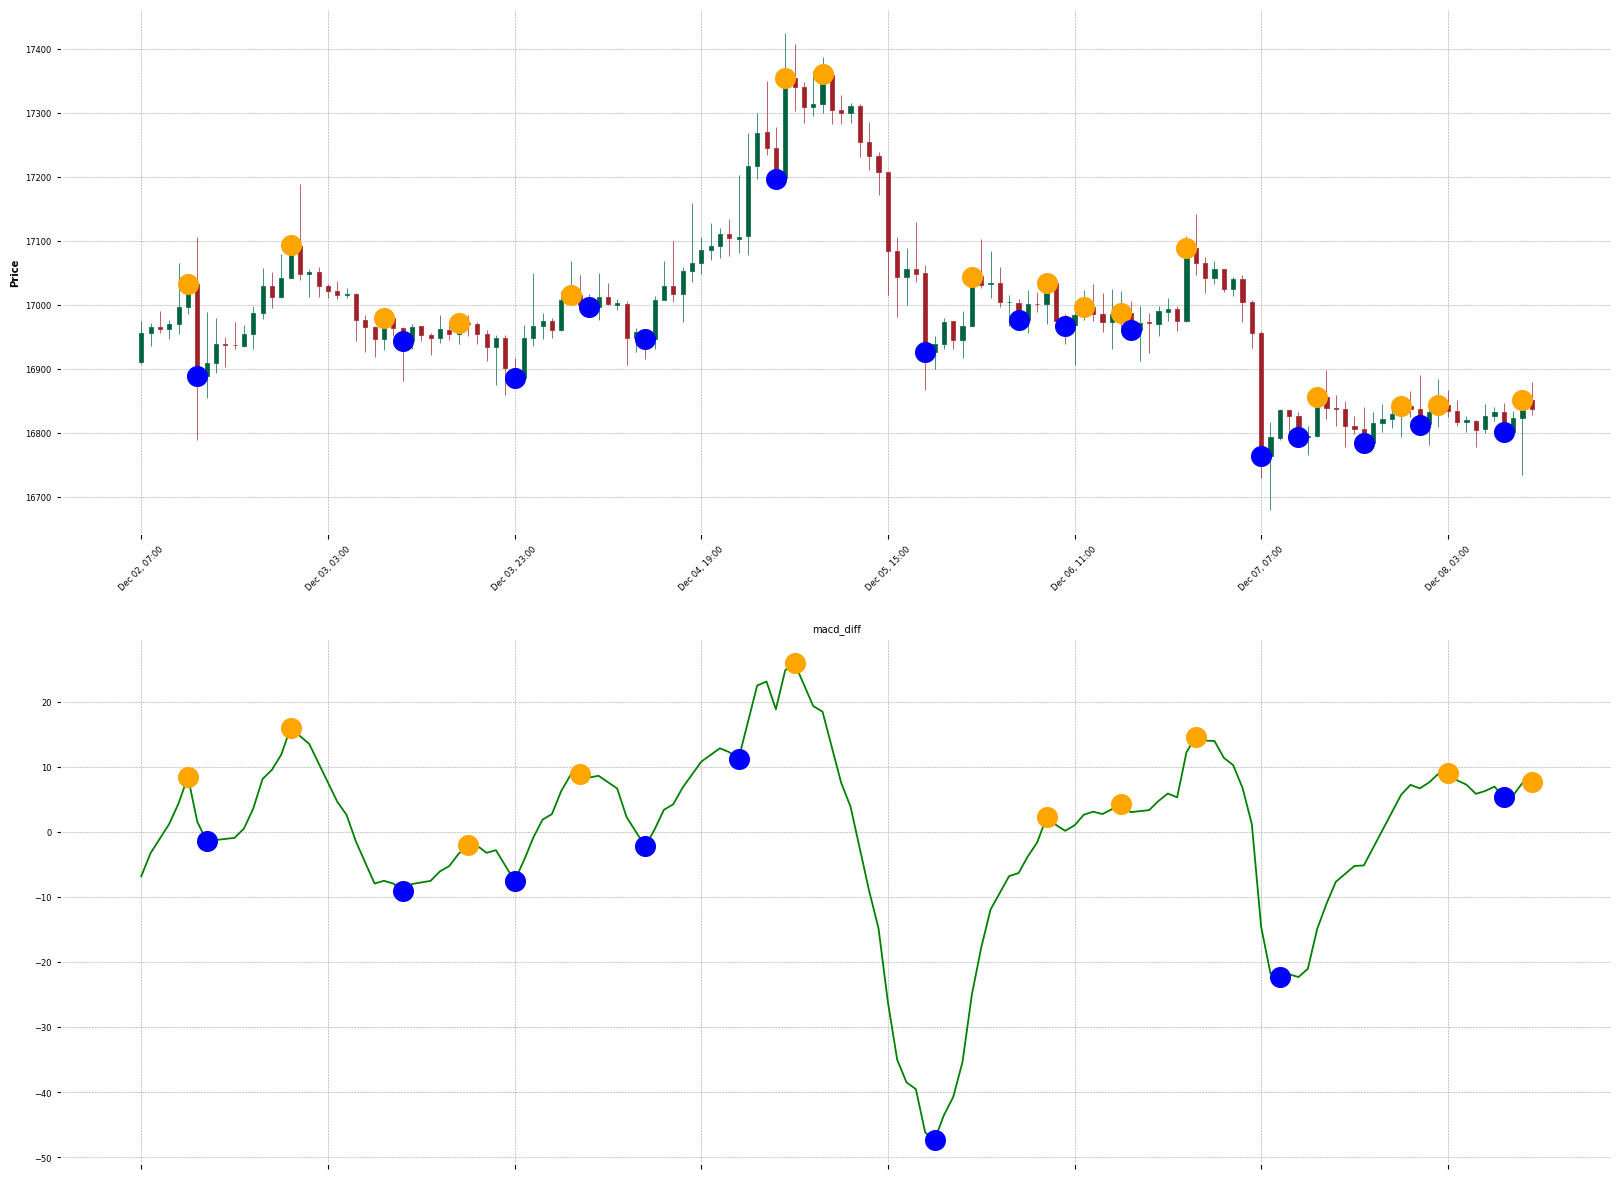

In [5]:
plot_top_bottom(df, INDICATOR_NAME, 450)

In [6]:
df_top = df.copy().loc[df[INDICATOR_NAME+"_top"] == 1]
df_top_indicator = df.copy().loc[df[COMPARATIVE_VALUE+"_top"] == 1]
div_top_obj = get_df_top_divergence(df_top, df_top_indicator, COMPARATIVE_VALUE, INDICATOR_NAME, True, 100)
df_div_top_bull = div_top_obj["top_bull_div"]
df_div_top_bear = div_top_obj["top_bear_div"]

df_bottom = df.copy().loc[df[INDICATOR_NAME+"_bottom"] == 1]
df_bottom_indicator = df.copy().loc[df["close_bottom"] == 1]
div_bottom_obj = get_df_bottom_divergence(df_bottom, df_bottom_indicator, COMPARATIVE_VALUE, INDICATOR_NAME, True, 100)
df_div_bottom_bull = div_bottom_obj["bottom_bull_div"]
df_div_bottom_bear = div_bottom_obj["bottom_bear_div"]

In [7]:
df_div_bottom_bear

,start_date,end_date,start_iloc,end_iloc,start_value,end_value,scope,start_indicator_value,end_indicator_value,indicator_scope
31,2017-09-05 16:00:00,2017-09-06 06:00:00,468,482,4142.69,4385.51,-1.662865,22.603890,-0.676227,17.344286
36,2017-09-14 17:00:00,2017-09-16 15:00:00,679,725,3325.27,3567.11,-0.003277,-32.528092,-32.678856,5.257391
38,2017-09-14 23:00:00,2017-09-16 15:00:00,685,725,3189.02,3567.11,-0.244864,-22.884302,-32.678856,9.452250
39,2017-09-15 11:00:00,2017-09-16 15:00:00,697,725,2919.00,3567.11,-0.276626,-24.933319,-32.678856,23.146786
49,2017-09-29 22:00:00,2017-09-30 21:00:00,1044,1067,4120.01,4317.88,-0.035881,-1.178389,-2.003650,8.603043
...,...,...,...,...,...,...,...,...,...,...
1432,2022-10-24 16:00:00,2022-10-27 02:00:00,45341,45399,19272.81,20685.06,-0.338756,-20.101969,-39.749812,24.349138
1433,2022-10-25 01:00:00,2022-10-27 02:00:00,45350,45399,19297.63,20685.06,-0.685904,-6.140504,-39.749812,28.314898
1434,2022-10-25 09:00:00,2022-10-27 02:00:00,45358,45399,19265.57,20685.06,-0.817194,-6.244840,-39.749812,34.621707
1450,2022-11-14 05:00:00,2022-11-16 15:00:00,45834,45892,15863.31,16431.70,-0.065358,-49.776183,-53.566944,9.799828


--- 242 Bullish Bottom Divergence detected
1 candle after the detection of a bullish bottom divergence we have a mean result of 0.01%
3 candles after the detection of a bullish bottom divergence we have a mean result of 0.01%
5 candles after the detection of a bullish bottom divergence we have a mean result of 0.1%
10 candles after the detection of a bullish bottom divergence we have a mean result of 0.0%
20 candles after the detection of a bullish bottom divergence we have a mean result of 0.68%
50 candles after the detection of a bullish bottom divergence we have a mean result of 1.27%
100 candles after the detection of a bullish bottom divergence we have a mean result of 1.47%


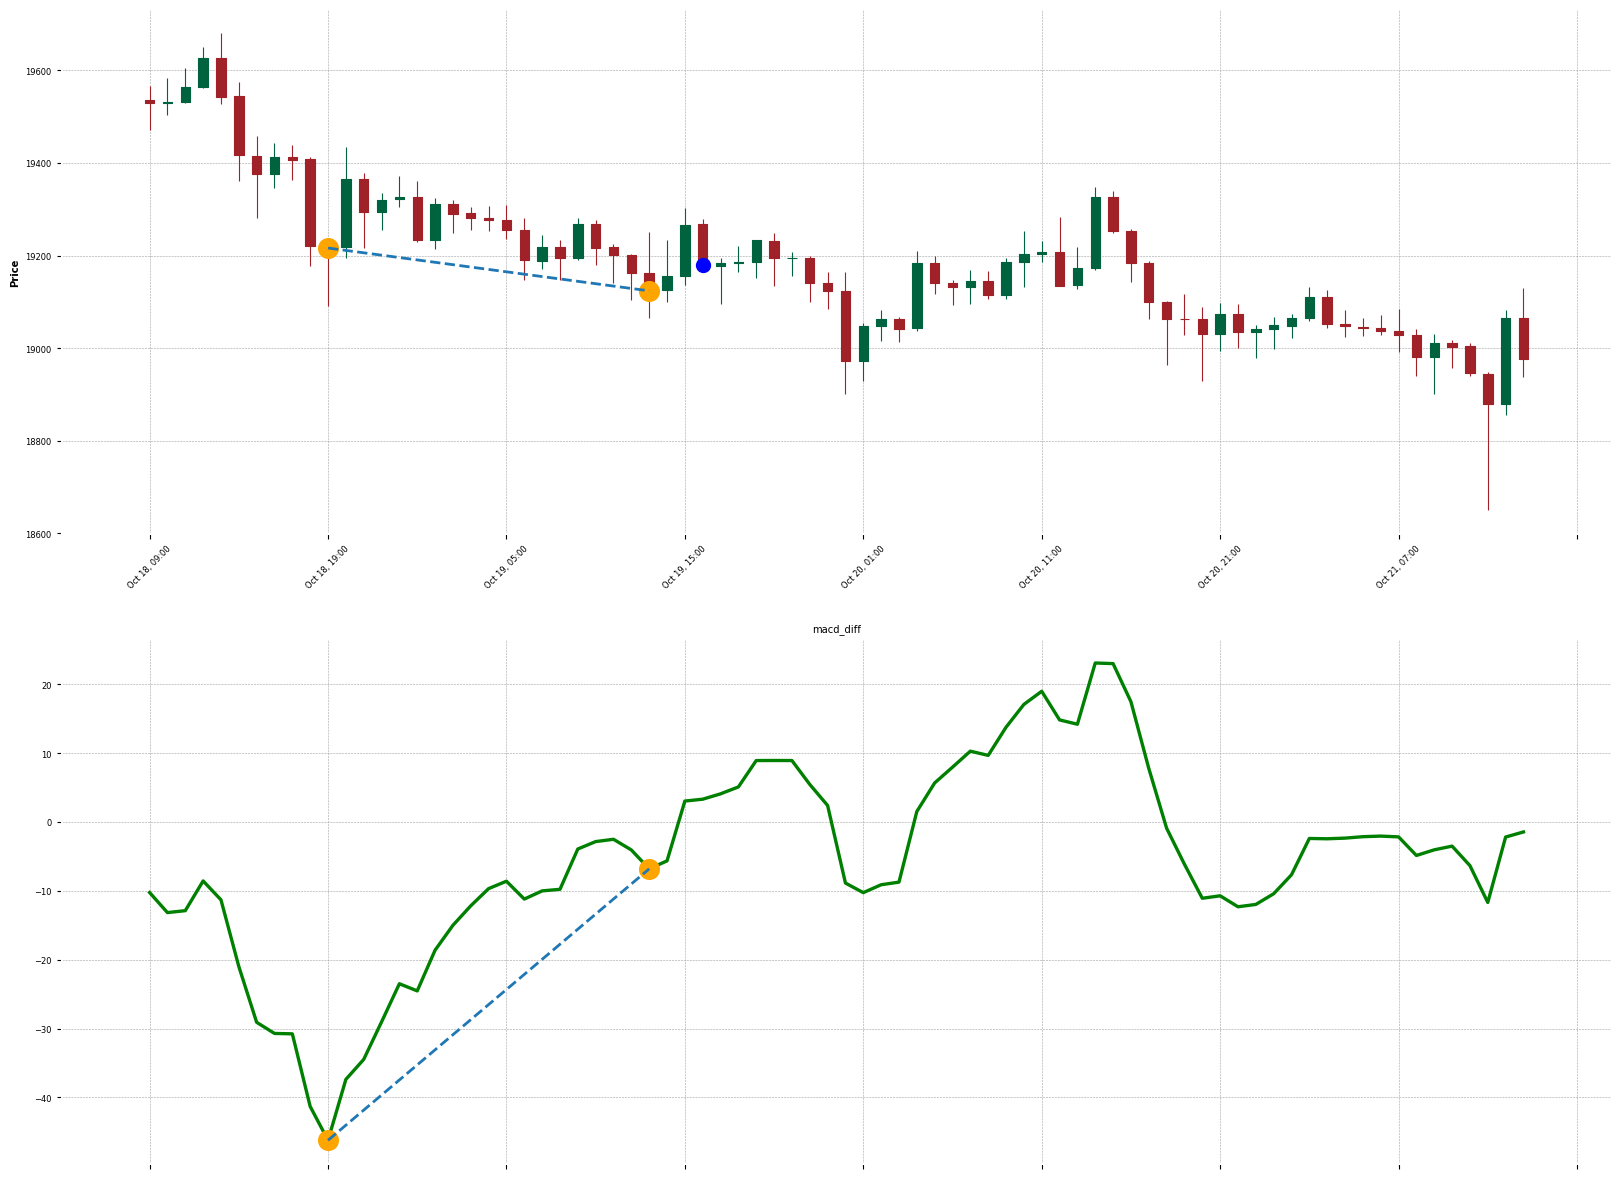

In [8]:
mean_reasult_after_1_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n1_result"] * 100).mean(), 2)
mean_reasult_after_3_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n3_result"] * 100).mean(), 2)
mean_reasult_after_5_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n5_result"] * 100).mean(), 2)
mean_reasult_after_10_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n10_result"] * 100).mean(), 2)
mean_reasult_after_20_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n20_result"] * 100).mean(), 2)
mean_reasult_after_50_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n50_result"] * 100).mean(), 2)
mean_reasult_after_100_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n100_result"] * 100).mean(), 2)

print(f"--- {len(df_div_bottom_bull)} Bullish Bottom Divergence detected")
print(f"1 candle after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_1_period}%")
print(f"3 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_3_period}%")
print(f"5 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_5_period}%")
print(f"10 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_10_period}%")
print(f"20 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_20_period}%")
print(f"50 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_50_period}%")
print(f"100 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_100_period}%")

plot_div(df, df_div_bottom_bull.iloc[len(df_div_bottom_bull)-10], INDICATOR_NAME, 3, 50)

--- 327 Bearish Bottom Divergence detected
1 candle after the detection of a bearish bottom divergence we have a mean result of -0.05%
3 candles after the detection of a bearish bottom divergence we have a mean result of -0.15%
5 candles after the detection of a bearish bottom divergence we have a mean result of -0.16%
10 candles after the detection of a bearish bottom divergence we have a mean result of -0.46%
20 candles after the detection of a bearish bottom divergence we have a mean result of -0.04%
50 candles after the detection of a bearish bottom divergence we have a mean result of 0.12%
100 candles after the detection of a bearish bottom divergence we have a mean result of 0.87%


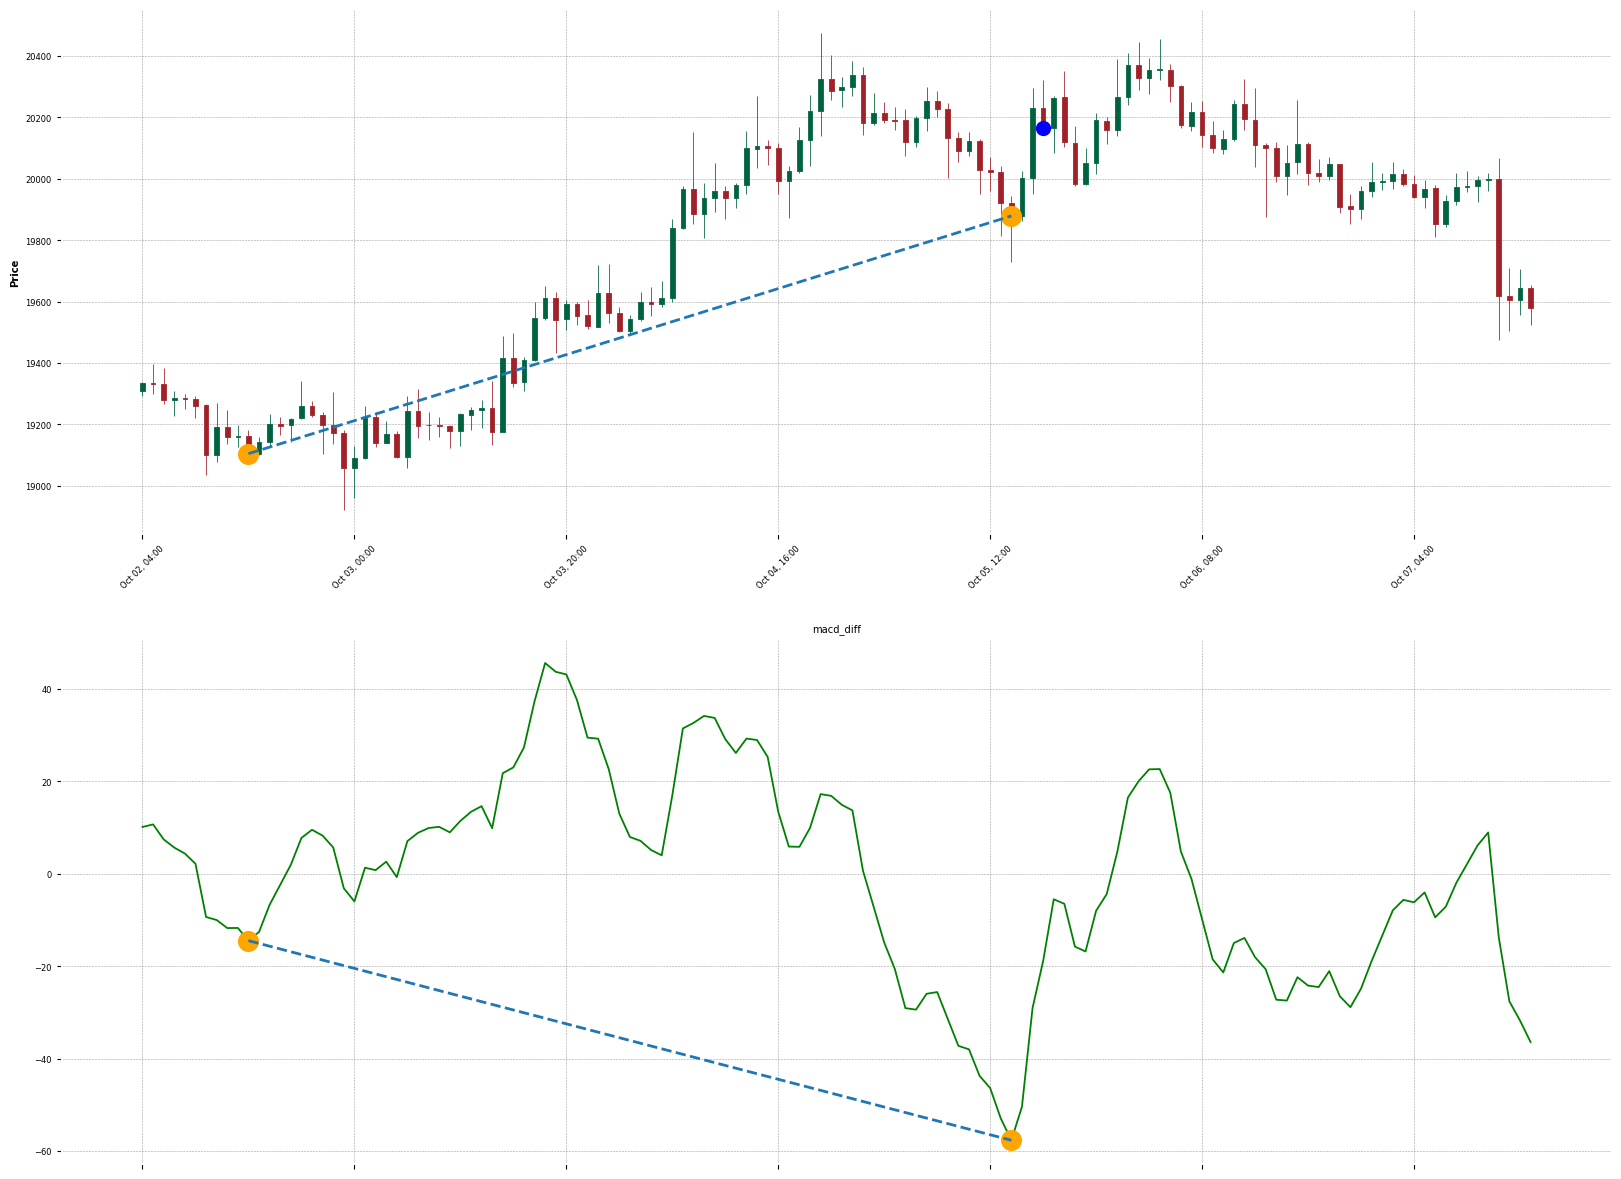

In [9]:
mean_reasult_after_1_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n1_result"] * 100).mean(), 2)
mean_reasult_after_3_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n3_result"] * 100).mean(), 2)
mean_reasult_after_5_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n5_result"] * 100).mean(), 2)
mean_reasult_after_10_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n10_result"] * 100).mean(), 2)
mean_reasult_after_20_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n20_result"] * 100).mean(), 2)
mean_reasult_after_50_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n50_result"] * 100).mean(), 2)
mean_reasult_after_100_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n100_result"] * 100).mean(), 2)

print(f"--- {len(df_div_bottom_bear)} Bearish Bottom Divergence detected")
print(f"1 candle after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_1_period}%")
print(f"3 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_3_period}%")
print(f"5 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_5_period}%")
print(f"10 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_10_period}%")
print(f"20 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_20_period}%")
print(f"50 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_50_period}%")
print(f"100 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_100_period}%")

plot_div(df, df_div_bottom_bear.iloc[len(df_div_bottom_bear)-10], INDICATOR_NAME, 3, 50)

--- 296 Bullish Top Divergence detected
1 candle after the detection of a bullish top divergence we have a mean result of -0.01%
3 candles after the detection of a bullish top divergence we have a mean result of 0.08%
5 candles after the detection of a bullish top divergence we have a mean result of 0.1%
10 candles after the detection of a bullish top divergence we have a mean result of 0.33%
20 candles after the detection of a bullish top divergence we have a mean result of 0.31%
50 candles after the detection of a bullish top divergence we have a mean result of 0.5%
100 candles after the detection of a bullish top divergence we have a mean result of 0.48%


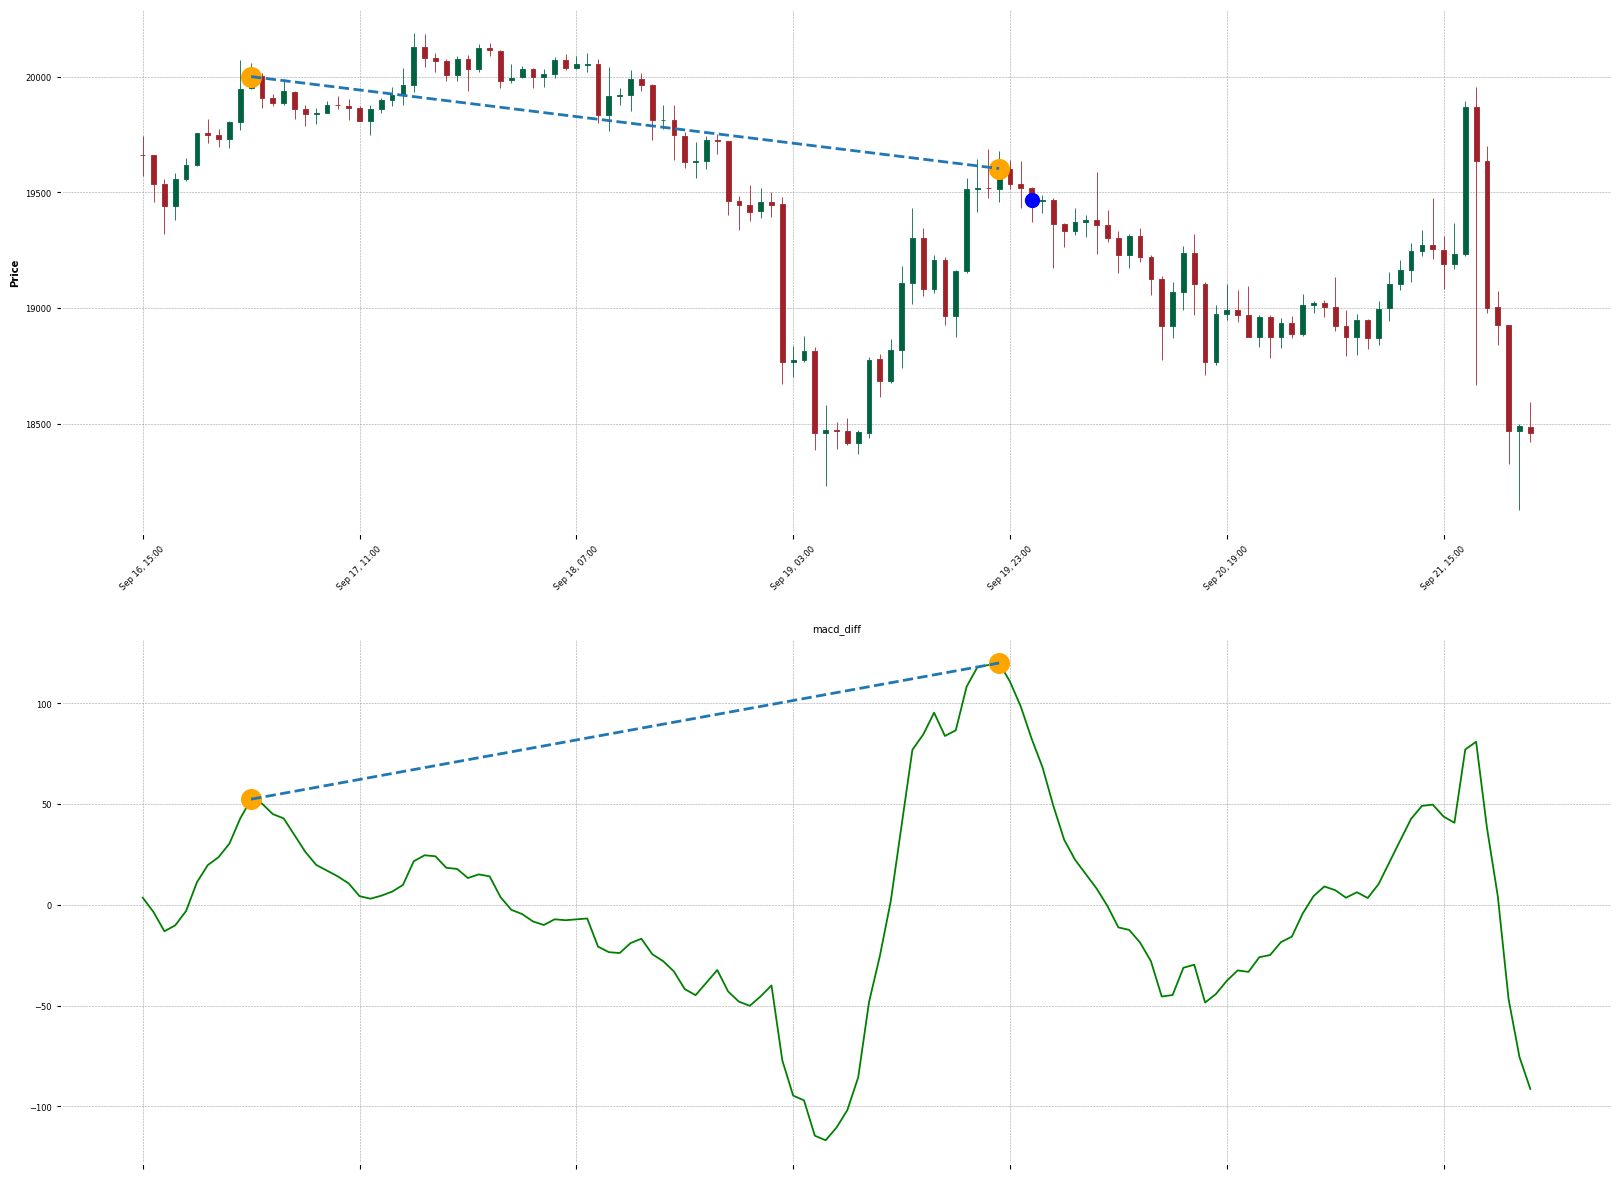

In [10]:
mean_reasult_after_1_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n1_result"] * 100).mean(), 2)
mean_reasult_after_3_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n3_result"] * 100).mean(), 2)
mean_reasult_after_5_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n5_result"] * 100).mean(), 2)
mean_reasult_after_10_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n10_result"] * 100).mean(), 2)
mean_reasult_after_20_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n20_result"] * 100).mean(), 2)
mean_reasult_after_50_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n50_result"] * 100).mean(), 2)
mean_reasult_after_100_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n100_result"] * 100).mean(), 2)

print(f"--- {len(df_div_top_bull)} Bullish Top Divergence detected")
print(f"1 candle after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_1_period}%")
print(f"3 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_3_period}%")
print(f"5 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_5_period}%")
print(f"10 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_10_period}%")
print(f"20 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_20_period}%")
print(f"50 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_50_period}%")
print(f"100 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_100_period}%")

plot_div(df, df_div_top_bull.iloc[len(df_div_top_bull) - 10], INDICATOR_NAME, 3, 50)

--- 284 Bearish Top Divergence detected
1 candle after the detection of a bearish top divergence we have a mean result of 0.05%
3 candles after the detection of a bearish top divergence we have a mean result of -0.07%
5 candles after the detection of a bearish top divergence we have a mean result of -0.18%
10 candles after the detection of a bearish top divergence we have a mean result of -0.18%
20 candles after the detection of a bearish top divergence we have a mean result of -0.04%
50 candles after the detection of a bearish top divergence we have a mean result of 0.6%
100 candles after the detection of a bearish top divergence we have a mean result of 1.47%


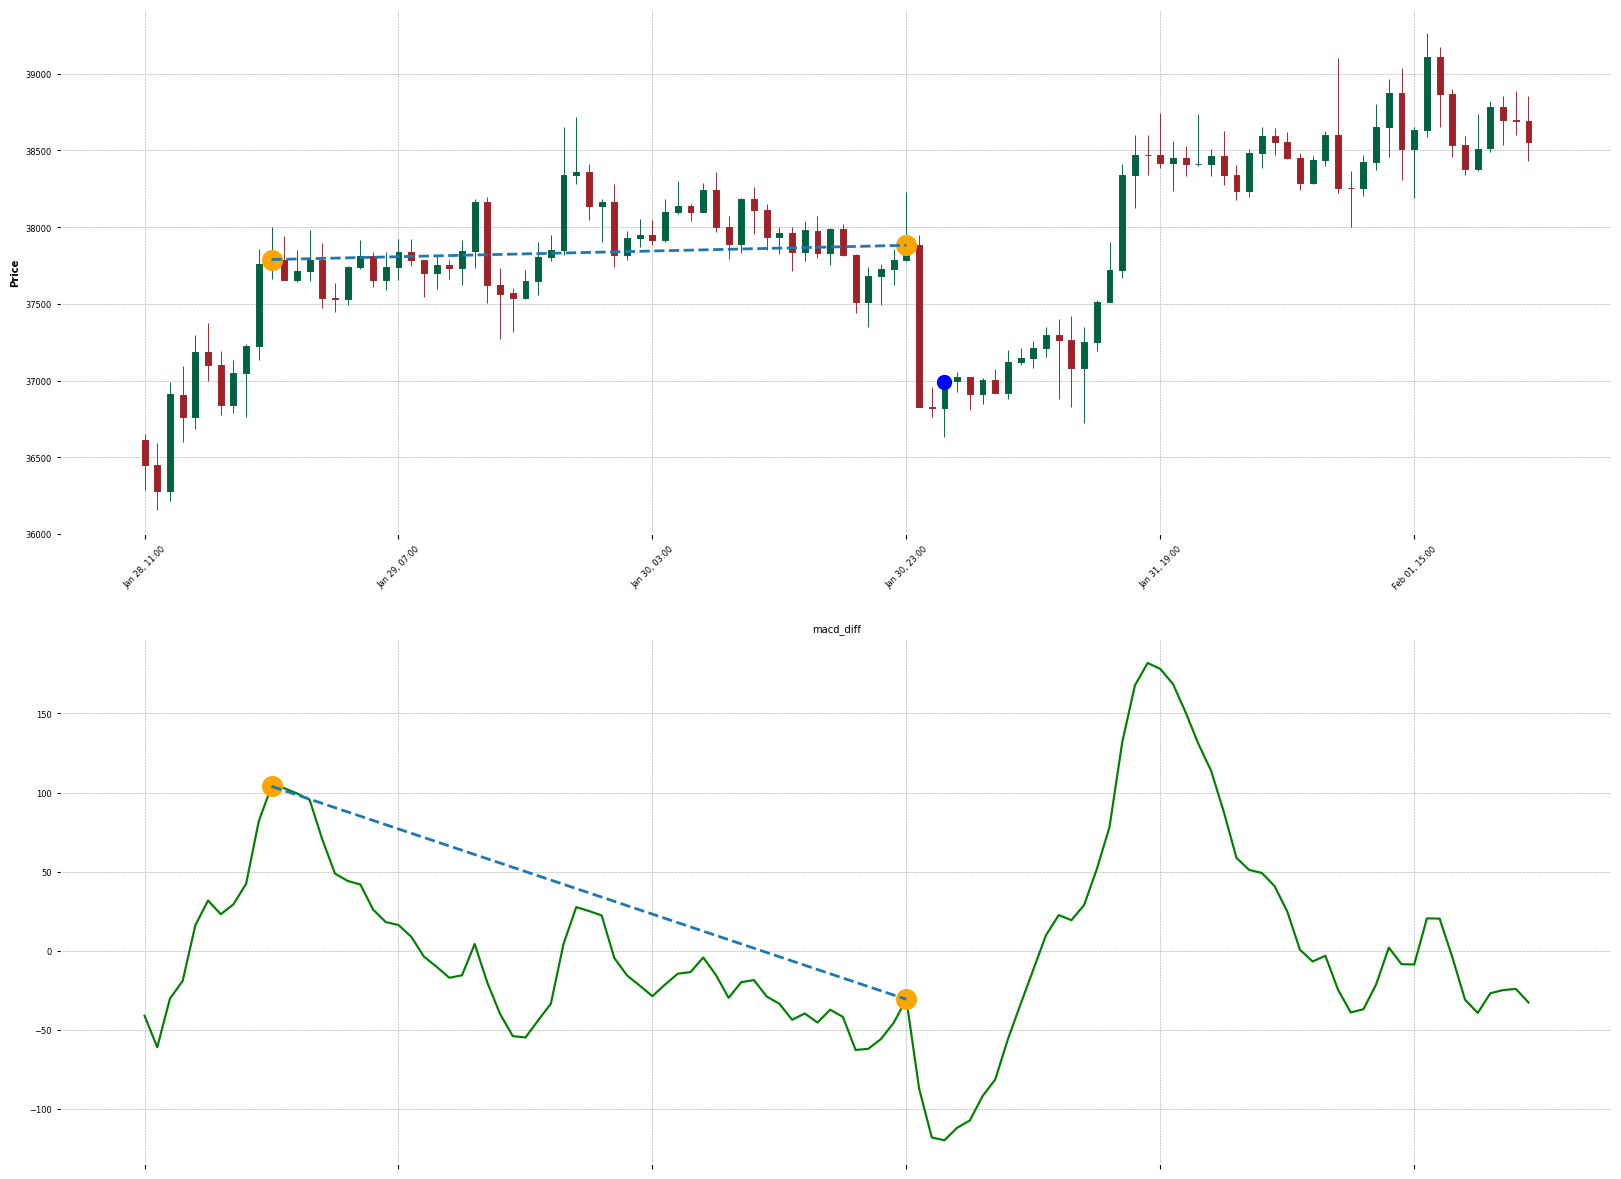

In [11]:
mean_reasult_after_1_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n1_result"] * 100).mean(), 2)
mean_reasult_after_3_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n3_result"] * 100).mean(), 2)
mean_reasult_after_5_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n5_result"] * 100).mean(), 2)
mean_reasult_after_10_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n10_result"] * 100).mean(), 2)
mean_reasult_after_20_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n20_result"] * 100).mean(), 2)
mean_reasult_after_50_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n50_result"] * 100).mean(), 2)
mean_reasult_after_100_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n100_result"] * 100).mean(), 2)

print(f"--- {len(df_div_top_bear)} Bearish Top Divergence detected")
print(f"1 candle after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_1_period}%")
print(f"3 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_3_period}%")
print(f"5 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_5_period}%")
print(f"10 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_10_period}%")
print(f"20 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_20_period}%")
print(f"50 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_50_period}%")
print(f"100 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_100_period}%")

plot_div(df, df_div_top_bear.iloc[len(df_div_top_bear) - 20], INDICATOR_NAME, 3, 50)